# Pretrained CNN (VGG)

In [ ]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=d87162c9e1a3a834ac990bda8168c885c9bca977a8f8c74e17bf3cf4e44426cf
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Colab Notebooks'

/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
import import_ipynb
import os
import tensorflow as tf
import numpy as np
import Utils as utils
from sklearn.utils import class_weight
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

importing Jupyter notebook from Utils.ipynb
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data preprocessing

In [ ]:
BATCH_SIZE = 32

In [ ]:
#Get datasets
images, labels = utils.load_training()
images, labels = utils.binarize(images, labels, 'benign_malignant')
images = utils.rescale(images)

#Shuffle
images, labels = utils.shuffle_dataset(images, labels)

In [ ]:
images = [np.stack((images[i],)*3, axis=2) for i in range (len(images))]
images = np.array(images)
utils.properties(images)

Properties: 
Shape: (2676, 150, 150, 3)
Min: 0.0
Max: 1.0
Diff: 1.0
Type of elements: float64


In [ ]:
data_augmentation = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    )


training_set = data_augmentation.flow(images, labels,seed=42, batch_size=BATCH_SIZE, subset='training')
validation_set = data_augmentation.flow(images, labels, seed=42, batch_size=BATCH_SIZE, subset='validation')


In [ ]:
weights = class_weight.compute_class_weight('balanced', np.unique(labels), labels)
weights = dict(enumerate(weights))
print('Class weights: ', weights)

Class weights:  {0: 0.8533163265306123, 1: 1.2075812274368232}


## Training

### Network architecture

In [ ]:
vgg16net = tf.keras.applications.VGG16(
  include_top=False,
  input_shape=(150,150,3),
  weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.Model(inputs=vgg16net.input, outputs=vgg16net.get_layer('block3_pool').output, name="vgg16"),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')                        
])
model.get_layer("vgg16").trainable=False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 18, 18, 256)       1735488   
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               42467840  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 44,367,681
Trainable params: 42,632,193
Non-trainable params: 1,735,488
__________________________________

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                   mode='max',
                                   patience=20,
                                   restore_best_weights=True),
  tf.keras.callbacks.ModelCheckpoint('models/vgg_bm_32_3.h5',
                                     monitor='val_accuracy',
                                     mode='max',
                                    save_best_only=True)]

history = model.fit(
      training_set,
      epochs=100,
      callbacks = callbacks,
      shuffle=False,
      verbose=1,
      validation_data=validation_set,
      batch_size=BATCH_SIZE)

Epoch 1/100
67/67 [==============================] - 14s 206ms/step - loss: 16.7961 - accuracy: 0.4995 - val_loss: 7.0496 - val_accuracy: 0.6037
Epoch 2/100
67/67 [==============================] - 14s 213ms/step - loss: 3.9305 - accuracy: 0.5461 - val_loss: 0.7704 - val_accuracy: 0.5869
Epoch 3/100
67/67 [==============================] - 14s 205ms/step - loss: 2.6108 - accuracy: 0.5744 - val_loss: 0.8864 - val_accuracy: 0.6523
Epoch 4/100
67/67 [==============================] - 14s 213ms/step - loss: 2.2208 - accuracy: 0.5693 - val_loss: 1.7283 - val_accuracy: 0.4523
Epoch 5/100
67/67 [==============================] - 14s 202ms/step - loss: 2.2821 - accuracy: 0.5382 - val_loss: 0.8568 - val_accuracy: 0.5234
Epoch 6/100
67/67 [==============================] - 14s 202ms/step - loss: 1.2524 - accuracy: 0.5730 - val_loss: 1.2874 - val_accuracy: 0.4729
Epoch 7/100
67/67 [==============================] - 14s 204ms/step - loss: 1.4360 - accuracy: 0.5461 - val_loss: 0.6219 - val_accuracy

### Training Plots

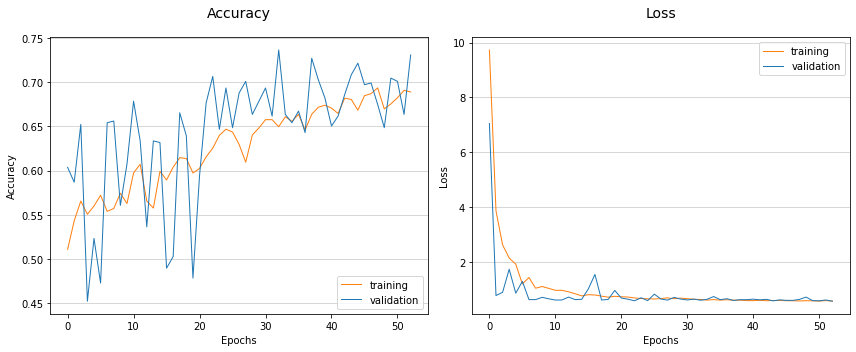

In [ ]:
utils.plot_training(history.history['accuracy'], 
                    history.history['loss'], 
                    history.history['val_accuracy'], 
                    history.history['val_loss'], 
                    53,
                    'figures/vgg_plotVGG16_bm_32_3.png')

## Evaluation

In [ ]:
test_images, test_labels = utils.load_test()
test_dataset, test_lab = utils.binarize(test_images, test_labels, 'benign_malignant')
test_dataset = utils.rescale(test_dataset)
test_dataset = [np.stack((test_dataset[i],)*3, axis=2) for i in range (len(test_dataset))]

11/11 [==============================] - 1s 48ms/step
Performances: 
Accuracy:  0.6726190476190477
Precision:  0.6592872314198479
Recall:  0.6726190476190477
F1-score:  0.6624149659863945
AUC:  0.6155016976934785


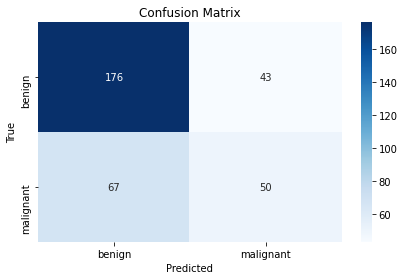

In [ ]:
test_dataset = np.array(test_dataset)
predicted = model.predict(test_dataset, verbose=1)
predicted = [0 if x <=0.5 else 1 for x in predicted]
utils.evaluate_classifier(test_lab, predicted)

utils.plot_confusion_matrix(test_lab, predicted, ['benign', 'malignant'], 'figures/vgg_bm_cm_32_3.png')